## Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# ! pip install aif360
# ! pip install cvxpy
# ! pip install BlackBoxAuditing

# import aif360
# !pip uninstall numpy
# !pip install numpy
! pip install ctgan
! pip install --upgrade category_encoders


# ! pip install table_evaluator
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import category_encoders as ce
import math
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
import os
from statistics import mean
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from datetime import datetime
import pprint
import json


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.7 MB/s eta 0:00:00


In [2]:
# Record the start time
start_time = time.time()

## Fairness metrics and functions


In [3]:
def print_metrics(y_gt, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_gt, y_pred).ravel()
    print('conf matrix:\n ', confusion_matrix(y_gt, y_pred) ,
          '\naccuracy: ', (tp+tn)/(tp+tn+fn+fp),
          'precision: ', tp/(tp+fp),
          'recall: ', tp/(tp+fn),
          'fpr: ', fp/(fp+tn),
          'tpr: ', tp /(tp + fn),
          'fn+fp', fn+fp)
    #returm fpr, tpr, accuracy
    return fp/(fp+tn), tp /(tp + fn), (tp+tn)/(tp+tn+fn+fp)

# bias metric - equal opportunity difference
def opportunity_diff_tpr(tpr1, tpr2):
    return abs(tpr1-tpr2)

# bias metric - equal opportunity difference
def opportunity_diff_fpr(fpr1, fpr2):
    return abs(fpr1-fpr2)

# bias metric - avarage absolute odds difference
def odds_diff(tpr1, tpr2, fpr1, fpr2):
    return 0.5*(abs(tpr2-tpr1) + abs(fpr2-fpr1))

# bias metric - statistical parity difference
def parity_diff(y_pred_0, y_pred_1):
    return abs(len(y_pred_0)/(len(y_pred_0)+len(y_pred_1)) - len(y_pred_1)/(len(y_pred_1)+len(y_pred_0)))


    # bias metric - Disparate impact
def disparate_impact(y_pred_0, y_pred_1):
    return min((len(y_pred_0)/len(y_pred_0+y_pred_1)) / (len(y_pred_1)/len(y_pred_1+len(y_pred_0)))
    ,(len(y_pred_1)/len(y_pred_0+y_pred_1)) / (len(y_pred_0)/len(y_pred_1+len(y_pred_0))))

In [4]:
# calculate the bias of divided dataset by the privileged feature
def calc_bias(data,y, priv_feature,y_pred, experiment_text):
    data_full =  pd.concat([data, y], axis=1)
    data_full['y_pred'] = y_pred

    label = TARGET_COL
    print('performance for whole ds:'+ experiment_text)
    fpr, tpr, acc = print_metrics(data_full[TARGET_COL], data_full['y_pred'] )

    feature_cat_list = list(data[priv_feature].unique())
    #print(feature_cat_list)
    valid_cat0 = data_full[data_full[priv_feature]==feature_cat_list[0]]
    valid_cat1 = data_full[data_full[priv_feature]==feature_cat_list[1]]
    print('performance for 0 sub-group:')
    fpr_0, tpr_0 , acc_0 = print_metrics(valid_cat0[TARGET_COL], valid_cat0['y_pred'])
    print('performance for 1 sub-group:')

    fpr_1, tpr_1, acc_1 = print_metrics(valid_cat1[TARGET_COL], valid_cat1['y_pred'])
    op_diff = opportunity_diff_tpr(tpr_0, tpr_1)
    op_diff_fpr = opportunity_diff_fpr(fpr_0, fpr_1)
    od_diff = odds_diff(tpr_0, tpr_1, fpr_0, fpr_1)
    par_diff = parity_diff(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    dis_impact = disparate_impact(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    print('bias metrics:')
    print('equal opportunity for tpr: (close to 0)', op_diff)
    print('equal opportunity for fpr: (close to 0)', op_diff_fpr)
    print('avarage absolute odds difference: (close to 0)',od_diff)
    print('statistical parity difference: (close to 0) ',par_diff)
    print('disparate_impact: (close to 1) ',dis_impact)

#     # Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#     # Bar colors
#     colors = ['blue', 'orange']

#     # Plot 1 - orig_data_one_priv and orig_data_one_non_priv
#     axs[0].bar(['priv', 'non_priv'], [tpr_0, tpr_1], color=colors)
#     axs[0].set_xlabel('Data Type')
#     axs[0].set_ylabel('Count')
#     axs[0].set_title('TPR(maximize)')

#     # Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
#     axs[1].bar(['priv', 'non_priv'], [fpr_0, fpr_1], color=colors)
#     axs[1].set_xlabel('Data Type')
#     axs[1].set_ylabel('Count')
#     axs[1].set_title('FPR(minimize)')

#     # Adjust spacing between subplots
#     plt.subplots_adjust(wspace=0.4)

#     # Show the plots
#     plt.show()

    return (op_diff,op_diff_fpr, od_diff,par_diff ,dis_impact,acc)

In [5]:
def fairness_metrics_roc_auc(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1234)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    std_op = np.std(op_list)
    op_str = f"{mean(op_list):.3f} ± {std_op:.3f}"

    std_op_f = np.std(op_f_list)
    op_f_str = f"{mean(op_f_list):.3f} ± {std_op_f:.3f}"

    std_od = np.std(od_list)
    od_str = f"{mean(od_list):.3f} ± {std_od:.3f}"

    std_par_dif = np.std(par_dif_list)
    par_dif_str = f"{mean(par_dif_list):.3f} ± {std_par_dif:.3f}"

    std_dis_impact = np.std(dis_impact_list)
    dis_imp_str = f"{mean(dis_impact_list):.3f} ± {std_dis_impact:.3f}"


    std_acc = np.std(acc_list)
    acc_str = f"{mean(acc_list):.3f} ± {std_acc:.3f}"
    time_elapsed_baseline = datetime.now() - start_time
    plot_roc_curve(fprs, tprs);
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    print('Accaracy list : ', acc_list)
    print('equal opportunity for tpr : ', op_list)
    print('equal opportunity for fpr : ',op_f_list)
    print('odds difference list : ' , od_list)
    print('The mean accuracy is ', acc_str)
    print('The mean equal opportunity for tpr: (close to 0)', op_str)
    print('The mean equal opportunity for fpr: (close to 0)', op_f_str)
    print('The mean odds difference: (close to 0)',od_str)
    print('The mean parity difference: (close to 0)', par_dif_str)
    print('The mean disperate impact: (close to 1)',dis_imp_str)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

In [6]:
def fairness_metrics_roc_auc_no_print(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5,random_state=100)

    cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

## Roc & AUC functions¶


In [7]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs, acc = [], []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))

    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index,clf ,data, y):
    y_predict = clf.predict_proba(data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

## Datasets & Params¶


In [8]:
# choose dataset
#DATASET_NAME = 'ADULT_SEX'
# DATASET_NAME = 'ADULT_RACE'
#DATASET_NAME ='COMPAS_RACE_AM'
#DATASET_NAME = 'COMPAS_SEX'
#DATASET_NAME='CREDIT_SEX'
#DATASET_NAME = 'BANK_AGE'
# DATASET_NAME = 'NURSERY'
DATASET_NAME = 'DEFAULT_CREDIT'



In [9]:
# upload kaggle.json file using user prompt
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!mkdir /root/.kaggle/
# Installing the Kaggle package
!pip install kaggle

#Important Note: complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
api_token = {"username":"guyrozenblatt","key":"e2ba3aff97edbcc7b8ab392e91dd8c65"}


# creating kaggle.json file with the personal API-Key details
# You can also put this file on your Google Drive
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json


!mkdir ./datasets/compastwoyears/compas-scores-two-years_v1.csv


Saving default of credit card clients.csv to default of credit card clients.csv
User uploaded file "default of credit card clients.csv" with length 2897209 bytes
mv: cannot stat 'kaggle.json': No such file or directory
mkdir: cannot create directory ‘/root/.kaggle/’: File exists
mkdir: cannot create directory ‘./datasets/compastwoyears/compas-scores-two-years_v1.csv’: No such file or directory


In [10]:
if DATASET_NAME == 'ADULT_SEX':
    TARGET_COL = 'income'
    PRIV_FEATURE = "sex"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    privileged_groups = [{'sex': 1}] # Male
    unprivileged_groups = [{'sex': 0}] # Female

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']


elif DATASET_NAME == 'ADULT_RACE':
    TARGET_COL = 'income'
    PRIV_FEATURE = "black"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data['black'] = np.where(orig_data['race'] == 'Black', 0,1)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'black']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']

elif DATASET_NAME =='COMPAS_RACE_AM':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'am'
#     PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']



elif DATASET_NAME =='COMPAS_SEX':
    orig_data = pd.read_csv('../input/compastwoyears/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']


elif DATASET_NAME == 'CREDIT_SEX':
    orig_data = pd.read_csv('../input/german-credit-data-with-risk/german_credit_data.csv')
    TARGET_COL = 'Risk'
    PRIV_FEATURE = 'Sex'
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 0
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'bad' else 1)
    orig_data['Sex'] = np.where(orig_data['Sex'] == 'male', 0,1)
    orig_data = orig_data.drop(["Unnamed: 0"],axis=1)
    orig_data['young'] = orig_data['Age'].apply(lambda x: 0 if x < 25 else 1)
    CATEGORICAL = ['Housing', 'Saving accounts' , 'Checking account', 'Purpose']
    feature_columns = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account','Credit amount', 'Duration', 'Purpose']

elif DATASET_NAME =='BANK_AGE':
    orig_data = pd.read_csv('/kaggle/input/bank-marketing-dataset/bank.csv')
    TARGET_COL = 'deposit'
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'no' else 1)

    orig_data['age_cat'] = np.where(((pd.to_numeric(orig_data['age']) > 65) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)
    PRIV_FEATURE = 'age_cat'
    PRIV_VALUE_FEATURE = 0
    PRIV_CLASS = 1
    feature_columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'age_cat',
       'previous', 'poutcome']
    CATEGORICAL = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

elif DATASET_NAME == "NURSERY":
    orig_data = pd.read_csv('/content/nursery.csv')
    TARGET_COL = 'class'
    PRIV_FEATURE = 'great_pret'
    PRIV_VALUE_FEATURE = 1
    PRIV_CLASS = 0
    orig_data['class'] = np.where(orig_data['class'] == 'spec_prior', 1,0)
    orig_data['great_pret'] = np.where(orig_data['parents'] == 'great_pret', 1,0)

    feature_columns = list(orig_data.columns)
    feature_columns.remove(TARGET_COL)
    CATEGORICAL = ['has_nurs','form','children','housing','finance','social','health','parents']

elif DATASET_NAME == "DEFAULT_CREDIT":
    orig_data = pd.read_csv('/content/default of credit card clients.csv')
    TARGET_COL = 'default payment next month'
    PRIV_FEATURE = 'SEX'
    PRIV_VALUE_FEATURE = 1
    PRIV_CLASS = 0

    feature_columns = list(orig_data.columns)
    feature_columns.remove(TARGET_COL)
    CATEGORICAL = []


In [11]:
orig_data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


## Data_Visualization

In [12]:
#Based on class
orig_data_one , orig_data_zero = [x for _, x in orig_data.groupby(orig_data[TARGET_COL] == 0)]

#Based on priv feature
orig_data_one_priv, orig_data_one_non_priv = [x for _, x in orig_data_one.groupby(orig_data_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
orig_data_zero_priv, orig_data_zero_non_priv = [x for _, x in orig_data_zero.groupby(orig_data_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(orig_data_one_priv.shape,orig_data_one_non_priv.shape,orig_data_zero_priv.shape,orig_data_zero_non_priv.shape)

(2873, 25) (3763, 25) (9015, 25) (14349, 25)


In [13]:
maximum = max(orig_data_zero_priv.shape,orig_data_zero_non_priv.shape,orig_data_one_priv.shape,orig_data_one_non_priv.shape)
if maximum == orig_data_zero_priv.shape:
    print("orig_data_zero_priv is maximum")
if maximum == orig_data_zero_non_priv.shape:
    print("orig_data_zero_non_priv is maximum")
if maximum == orig_data_one_priv.shape:
    print("orig_data_one_priv is maximum")
if maximum == orig_data_one_non_priv.shape:
    print("orig_data_one_non_priv is maximum")

orig_data_zero_non_priv is maximum


In [14]:
maximum = maximum[0]
print(maximum)

14349


In [15]:
orig_data_zero_priv.shape[0]

9015

In [16]:
orig_data_one_non_priv

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
21,22,120000,2,2,1,39,-1,-1,-1,-1,...,0,632,316,316,316,0,632,316,0,1
22,23,70000,2,2,2,26,2,0,0,2,...,44006,46905,46012,2007,3582,0,3601,0,1820,1
23,24,450000,2,1,1,40,-2,-2,-2,-2,...,560,0,0,19428,1473,560,0,0,1128,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29169,29170,20000,2,3,1,56,1,3,2,2,...,9376,9720,10962,0,1200,0,500,1400,0,1
29170,29171,60000,2,2,2,53,1,2,0,0,...,10226,12041,11704,0,1000,1226,2000,0,1100,1
29176,29177,240000,2,2,1,56,3,2,2,-2,...,0,0,0,0,0,0,0,0,0,1
29179,29180,500000,2,2,1,73,-2,-2,-2,-2,...,2835,8896,3850,2826,2652,2835,8896,3850,711,1


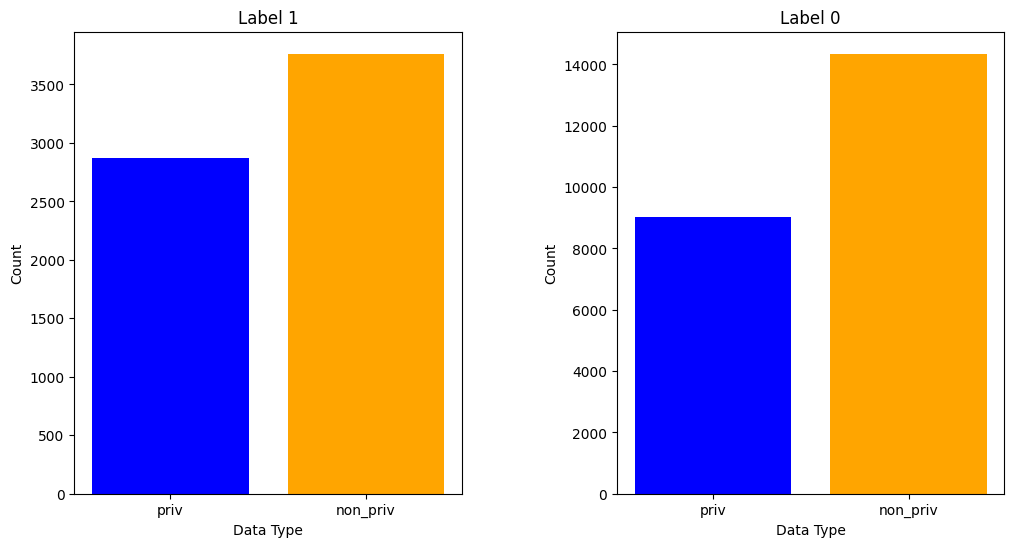

In [17]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [orig_data_one_priv.shape[0], orig_data_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [orig_data_zero_priv.shape[0], orig_data_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')


# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plots
plt.show()

In [18]:
orig_data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [19]:
# dataset for training
orig_data.dropna(thresh=len(feature_columns)/2, inplace=True)
orig_data.reset_index(drop=True, inplace=True)

y_orig = orig_data[TARGET_COL]
# y_orig = orig_data[TARGET_COL].to_frame()

y_orig.dropna(inplace=True)

orig_data = orig_data.loc[:, feature_columns]
# data = data[feature_columns]
encoder = ce.TargetEncoder(cols=CATEGORICAL)

encoder.fit(orig_data, y_orig)
orig_data_encoded = encoder.transform(orig_data)

In [20]:
orig_dataset = pd.concat([orig_data, y_orig], axis=1)


## Acc, fairness metrics and roc & auc for original dataset

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[4508  164]
 [ 918  410]] 
accuracy:  0.8196666666666667 precision:  0.7142857142857143 recall:  0.30873493975903615 fpr:  0.0351027397260274 tpr:  0.30873493975903615 fn+fp 1082
performance for 0 sub-group:
conf matrix:
  [[2791   98]
 [ 510  241]] 
accuracy:  0.832967032967033 precision:  0.7109144542772862 recall:  0.3209054593874834 fpr:  0.033921772239529246 tpr:  0.3209054593874834 fn+fp 608
performance for 1 sub-group:
conf matrix:
  [[1717   66]
 [ 408  169]] 
accuracy:  0.7991525423728814 precision:  0.7191489361702128 recall:  0.292894280762565 fpr:  0.03701626472237801 tpr:  0.292894280762565 fn+fp 474
bias metrics:
equal opportunity for tpr: (close to 0) 0.028011178624918365
equal opportunity for fpr: (close to 0) 0.003094492482848765
avarage absolute odds difference: (close to 0) 0.015552835553883565
statistical parity difference: (close to 0)  0.18118466898954705
disparate_impact: (close to

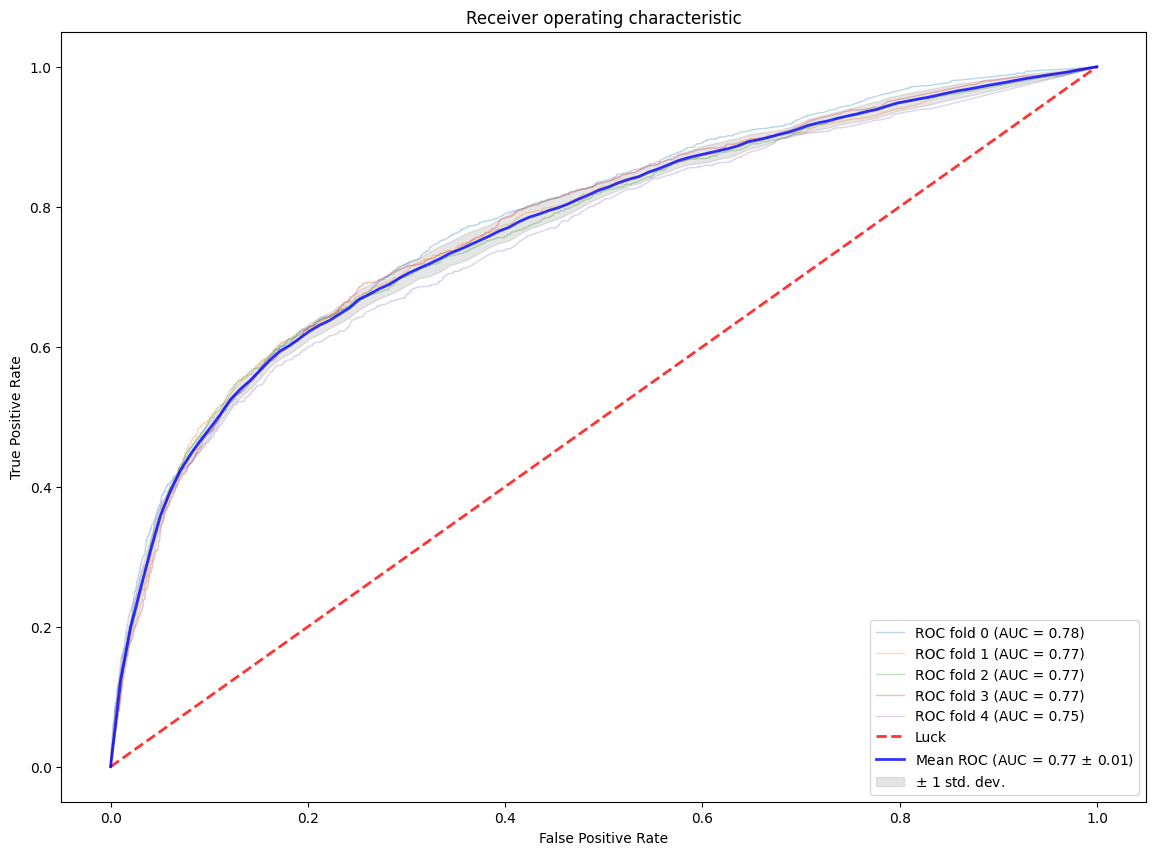

Accaracy list :  [0.8196666666666667, 0.8143333333333334, 0.813, 0.8103333333333333, 0.8176666666666667]
equal opportunity for tpr :  [0.028011178624918365, 0.010844663810765487, 0.045343154126798346, 0.032509783144177073, 0.0025901942645698006]
equal opportunity for fpr :  [0.003094492482848765, 0.013742625667891376, 0.011347021339599202, 0.011929758316816773, 0.009701962152741703]
odds difference list :  [0.015552835553883565, 0.012293644739328431, 0.028345087733198774, 0.022219770730496923, 0.006146078208655752]
The mean accuracy is  0.815 ± 0.003
The mean equal opportunity for tpr: (close to 0) 0.024 ± 0.015
The mean equal opportunity for fpr: (close to 0) 0.010 ± 0.004
The mean odds difference: (close to 0) 0.017 ± 0.008
The mean parity difference: (close to 0) 0.110 ± 0.049
The mean disperate impact: (close to 1) 0.399 ± 0.063


In [21]:
orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact  = fairness_metrics_roc_auc(orig_data_encoded, y_orig)

  ## CTGANfor each group

In [22]:
zero_priv_toincrease = maximum - orig_data_zero_priv.shape[0] ## where class is 0 attribute is 1
zero_nonpriv_toincresed = maximum - orig_data_zero_non_priv.shape[0] ## where class is 1 attribute is 0
one_priv_toincresed = maximum - orig_data_one_priv.shape[0] ## where class is 1 attribute is 1
one_nonpriv_toincresed = maximum - orig_data_one_non_priv.shape[0] ## where class is 1 attribute is 1


print(zero_priv_toincrease,zero_nonpriv_toincresed,one_priv_toincresed,one_nonpriv_toincresed)

5334 0 11476 10586


# CTGAN On Priv Target Group

In [23]:
from ctgan import CTGAN

# Fit CTGAN for orig_data_zero_priv

ctgan_zero_priv = CTGAN(verbose=True)
ctgan_zero_priv.fit(orig_data_zero_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_zero_non_priv

ctgan_zero_nonpriv = CTGAN(verbose=True)
ctgan_zero_nonpriv.fit(orig_data_zero_non_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_one_priv

ctgan_one_priv = CTGAN(verbose=True)
ctgan_one_priv.fit(orig_data_one_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_one_non_priv

ctgan_one_nonpriv = CTGAN(verbose=True)
ctgan_one_nonpriv.fit(orig_data_one_non_priv , CATEGORICAL, epochs = 200)



Gen. (-0.13) | Discrim. (0.06): 100%|██████████| 200/200 [07:55<00:00,  2.38s/it]
Gen. (-0.44) | Discrim. (-0.17): 100%|██████████| 200/200 [12:58<00:00,  3.89s/it]
Gen. (0.03) | Discrim. (-0.11): 100%|██████████| 200/200 [01:53<00:00,  1.77it/s]
Gen. (-1.32) | Discrim. (0.14): 100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


In [24]:
zero_priv_toincrease = maximum - orig_data_zero_priv.shape[0] ## where class is 0 attribute is 1
zero_nonpriv_toincresed = maximum - orig_data_zero_non_priv.shape[0] ## where class is 1 attribute is 0
one_priv_toincresed = maximum - orig_data_one_priv.shape[0] ## where class is 1 attribute is 1
one_nonpriv_toincresed = maximum - orig_data_one_non_priv.shape[0] ## where class is 1 attribute is 1

#create samples using ctgan with zero_priv
zero_priv_samples = ctgan_zero_priv.sample(zero_priv_toincrease)


#create samples using ctgan with zero_nonpriv
zero_nonpriv_samples = ctgan_zero_nonpriv.sample(zero_nonpriv_toincresed)


#create samples using ctgan with one_priv
one_priv_samples = ctgan_one_priv.sample(one_priv_toincresed)


#create samples using ctgan with zero_priv
one_nonpriv_samples = ctgan_one_nonpriv.sample(one_nonpriv_toincresed)



In [25]:
Upsampled_Dataset = pd.concat([orig_dataset, zero_priv_samples, zero_nonpriv_samples, one_priv_samples, one_nonpriv_samples], ignore_index=True)

Upsampled_Dataset = Upsampled_Dataset.reset_index()


In [26]:
Upsampled_Dataset

,index,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0,1,20000,2,2,1,24,2,2,-1,...,0,0,0,0,689,0,0,0,0,1
1,1,2,120000,2,2,2,26,-1,2,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,2,3,90000,2,2,2,34,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,3,4,50000,2,2,1,37,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,4,5,50000,1,2,1,57,-1,0,-1,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57391,57391,4817,309686,2,3,2,38,2,2,2,...,-708,94160,44,8190,2790,687,12251,-1012,1074,1
57392,57392,22193,246758,2,2,1,67,1,-1,-2,...,-3866,6496,2416,705,-400,-1042,-617,-778,-112,1
57393,57393,481,20748,2,1,2,35,2,2,0,...,310862,-4240,1041,9304,618,1526,2496,1606,544,1
57394,57394,19941,175119,2,3,2,46,2,2,0,...,-1015,144819,41764,1009,3040,-272,912,-1146,4077,1


In [27]:
Upsampled_df_features = Upsampled_Dataset.loc[:, feature_columns]

Upsampled_df_features = encoder.transform(Upsampled_df_features)
Upsampled_df_features

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000,2,2,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
1,2,120000,2,2,2,26,-1,2,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,3,90000,2,2,2,34,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,4,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,5,50000,1,2,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57391,4817,309686,2,3,2,38,2,2,2,2,...,25558,-708,94160,44,8190,2790,687,12251,-1012,1074
57392,22193,246758,2,2,1,67,1,-1,-2,-2,...,3386,-3866,6496,2416,705,-400,-1042,-617,-778,-112
57393,481,20748,2,1,2,35,2,2,0,0,...,192639,310862,-4240,1041,9304,618,1526,2496,1606,544
57394,19941,175119,2,3,2,46,2,2,0,2,...,114114,-1015,144819,41764,1009,3040,-272,912,-1146,4077


performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[5350  390]
 [1279 4461]] 
accuracy:  0.854616724738676 precision:  0.9196042053184911 recall:  0.777177700348432 fpr:  0.06794425087108014 tpr:  0.777177700348432 fn+fp 1669
performance for 0 sub-group:
conf matrix:
  [[2678  157]
 [ 549 2329]] 
accuracy:  0.8764221949938736 precision:  0.9368463395012068 recall:  0.8092425295343989 fpr:  0.055379188712522044 tpr:  0.8092425295343989 fn+fp 706
performance for 1 sub-group:
conf matrix:
  [[2672  233]
 [ 730 2132]] 
accuracy:  0.8330154326339518 precision:  0.9014799154334038 recall:  0.7449336128581412 fpr:  0.0802065404475043 tpr:  0.7449336128581412 fn+fp 963
bias metrics:
equal opportunity for tpr: (close to 0) 0.06430891667625771
equal opportunity for fpr: (close to 0) 0.02482735173498226
avarage absolute odds difference: (close to 0) 0.04456813420561999
statistical parity difference: (close to 0)  0.024943310657596418
disparate_impact: (close to 1) 

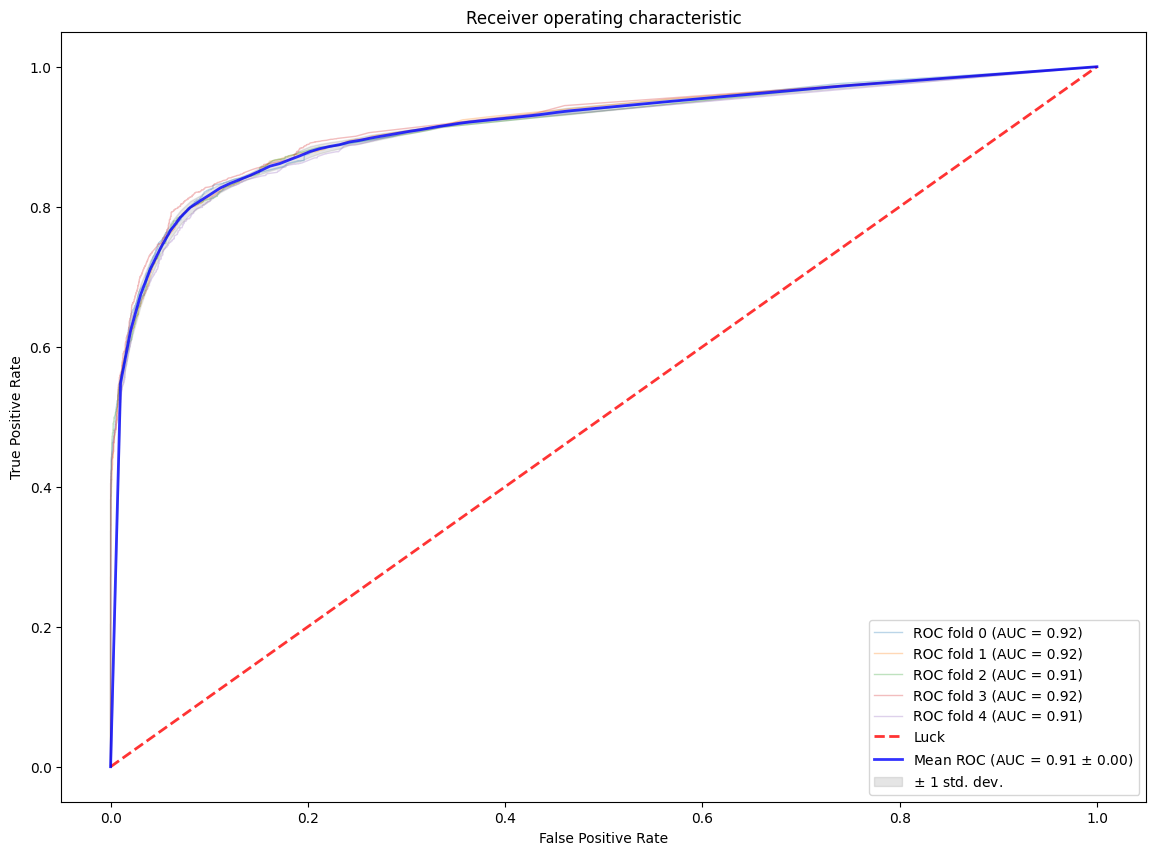

Accaracy list :  [0.854616724738676, 0.857043296454395, 0.8573046432616082, 0.8662775503092603, 0.8525132851293666]
equal opportunity for tpr :  [0.06430891667625771, 0.0422266133658723, 0.03802595037559753, 0.037205270154448966, 0.04236440634726257]
equal opportunity for fpr :  [0.02482735173498226, 0.010968470339903405, 0.02188544541730903, 0.03178216837205812, 0.015360846032057646]
odds difference list :  [0.04456813420561999, 0.026597541852887853, 0.02995569789645328, 0.03449371926325354, 0.02886262618966011]
The mean accuracy is  0.858 ± 0.005
The mean equal opportunity for tpr: (close to 0) 0.045 ± 0.010
The mean equal opportunity for fpr: (close to 0) 0.021 ± 0.007
The mean odds difference: (close to 0) 0.033 ± 0.006
The mean parity difference: (close to 0) 0.018 ± 0.009
The mean disperate impact: (close to 1) 0.478 ± 0.016


In [28]:
y_upsampled = Upsampled_Dataset[TARGET_COL]

# Check fairness metrics again
upsampled_acc, upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff, upsampled_dis_impact = fairness_metrics_roc_auc(Upsampled_df_features, y_upsampled)

# # Store metrics values
# op_diff_values.append(mean(debias_op_diff))
# dis_impact_values.append(mean(debias_dis_impact))
# debias_acc_values.append(mean(debias_acc))
# debias_odds_diff_values.append(mean(debias_od_diff))
# alfa_counter += 1
# print('alfa counter is :',alfa_counter)
# print ('debias_op_diff is {} , orig_op_diff is {}'.format(mean(debias_op_diff), mean(orig_op_diff)))
# print ('debias_dis_impact is {} , orig_dis_impact is {}'.format(mean(debias_dis_impact), mean(orig_dis_impact)) )

In [29]:
#Based on class
Upsampled_Dataset_one , Upsampled_Dataset_zero = [x for _, x in Upsampled_Dataset.groupby(Upsampled_Dataset[TARGET_COL] == 0)]

#Based on priv feature
Upsampled_df_one_priv, Upsampled_df_one_non_priv = [x for _, x in Upsampled_Dataset_one.groupby(Upsampled_Dataset_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
Upsampled_df_zero_priv, Upsampled_df_zero_non_priv = [x for _, x in Upsampled_Dataset_zero.groupby(Upsampled_Dataset_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(Upsampled_df_one_priv.shape,Upsampled_df_one_non_priv.shape,Upsampled_df_zero_priv.shape,Upsampled_df_zero_non_priv.shape)

(14349, 26) (14349, 26) (14349, 26) (14349, 26)


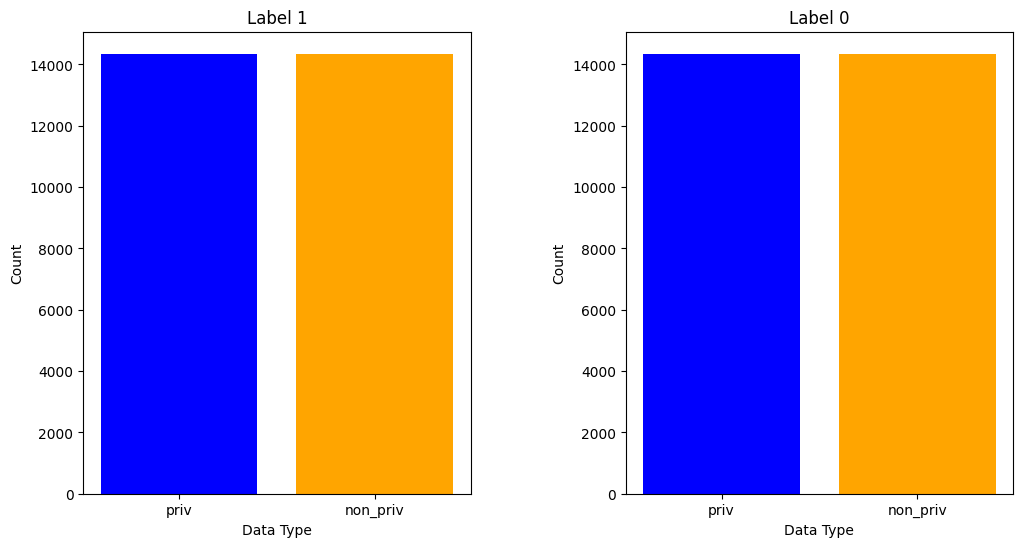

In [30]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [Upsampled_df_one_priv.shape[0], Upsampled_df_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [Upsampled_df_zero_priv.shape[0], Upsampled_df_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plots
plt.show()

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[5350  390]
 [1279 4461]] 
accuracy:  0.854616724738676 precision:  0.9196042053184911 recall:  0.777177700348432 fpr:  0.06794425087108014 tpr:  0.777177700348432 fn+fp 1669
performance for 0 sub-group:
conf matrix:
  [[2678  157]
 [ 549 2329]] 
accuracy:  0.8764221949938736 precision:  0.9368463395012068 recall:  0.8092425295343989 fpr:  0.055379188712522044 tpr:  0.8092425295343989 fn+fp 706
performance for 1 sub-group:
conf matrix:
  [[2672  233]
 [ 730 2132]] 
accuracy:  0.8330154326339518 precision:  0.9014799154334038 recall:  0.7449336128581412 fpr:  0.0802065404475043 tpr:  0.7449336128581412 fn+fp 963
bias metrics:
equal opportunity for tpr: (close to 0) 0.06430891667625771
equal opportunity for fpr: (close to 0) 0.02482735173498226
avarage absolute odds difference: (close to 0) 0.04456813420561999
statistical parity difference: (close to 0)  0.024943310657596418
disparate_impact: (close to 1) 

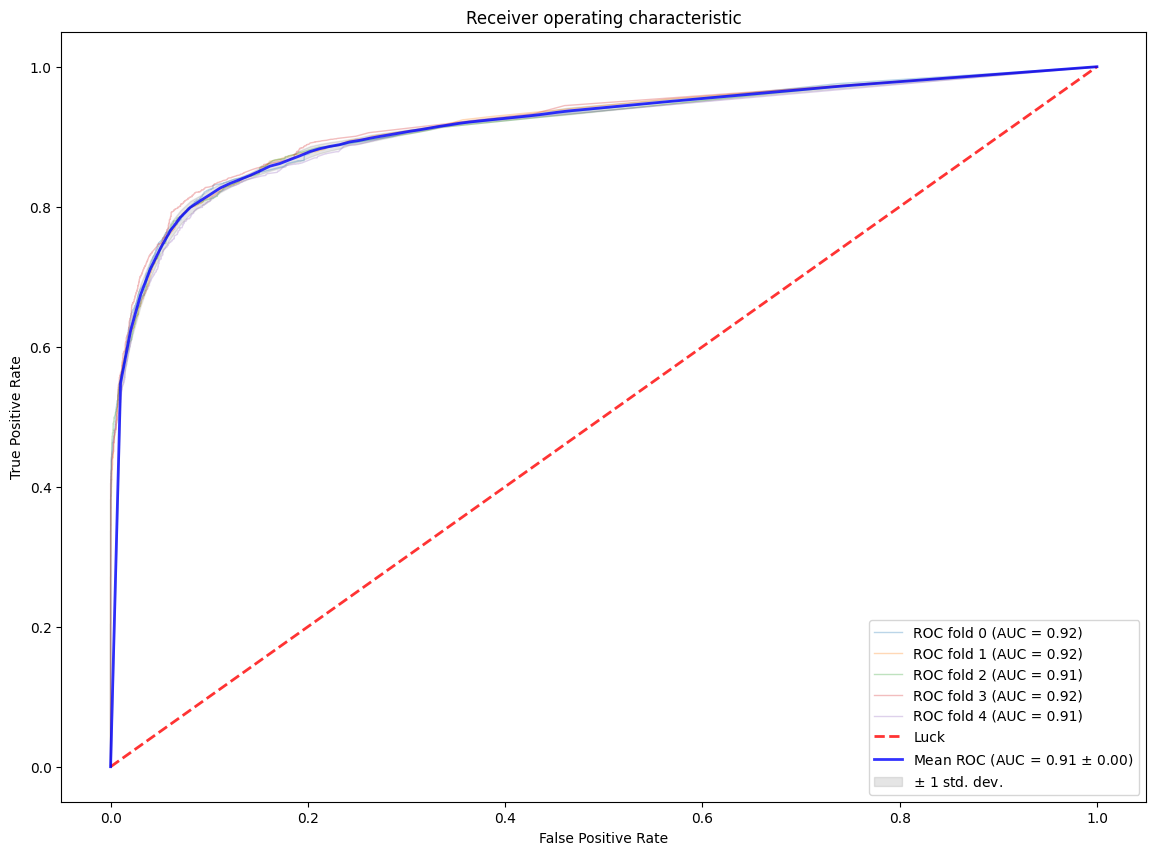

Accaracy list :  [0.854616724738676, 0.857043296454395, 0.8573046432616082, 0.8662775503092603, 0.8525132851293666]
equal opportunity for tpr :  [0.06430891667625771, 0.0422266133658723, 0.03802595037559753, 0.037205270154448966, 0.04236440634726257]
equal opportunity for fpr :  [0.02482735173498226, 0.010968470339903405, 0.02188544541730903, 0.03178216837205812, 0.015360846032057646]
odds difference list :  [0.04456813420561999, 0.026597541852887853, 0.02995569789645328, 0.03449371926325354, 0.02886262618966011]
The mean accuracy is  0.858 ± 0.005
The mean equal opportunity for tpr: (close to 0) 0.045 ± 0.010
The mean equal opportunity for fpr: (close to 0) 0.021 ± 0.007
The mean odds difference: (close to 0) 0.033 ± 0.006
The mean parity difference: (close to 0) 0.018 ± 0.009
The mean disperate impact: (close to 1) 0.478 ± 0.016


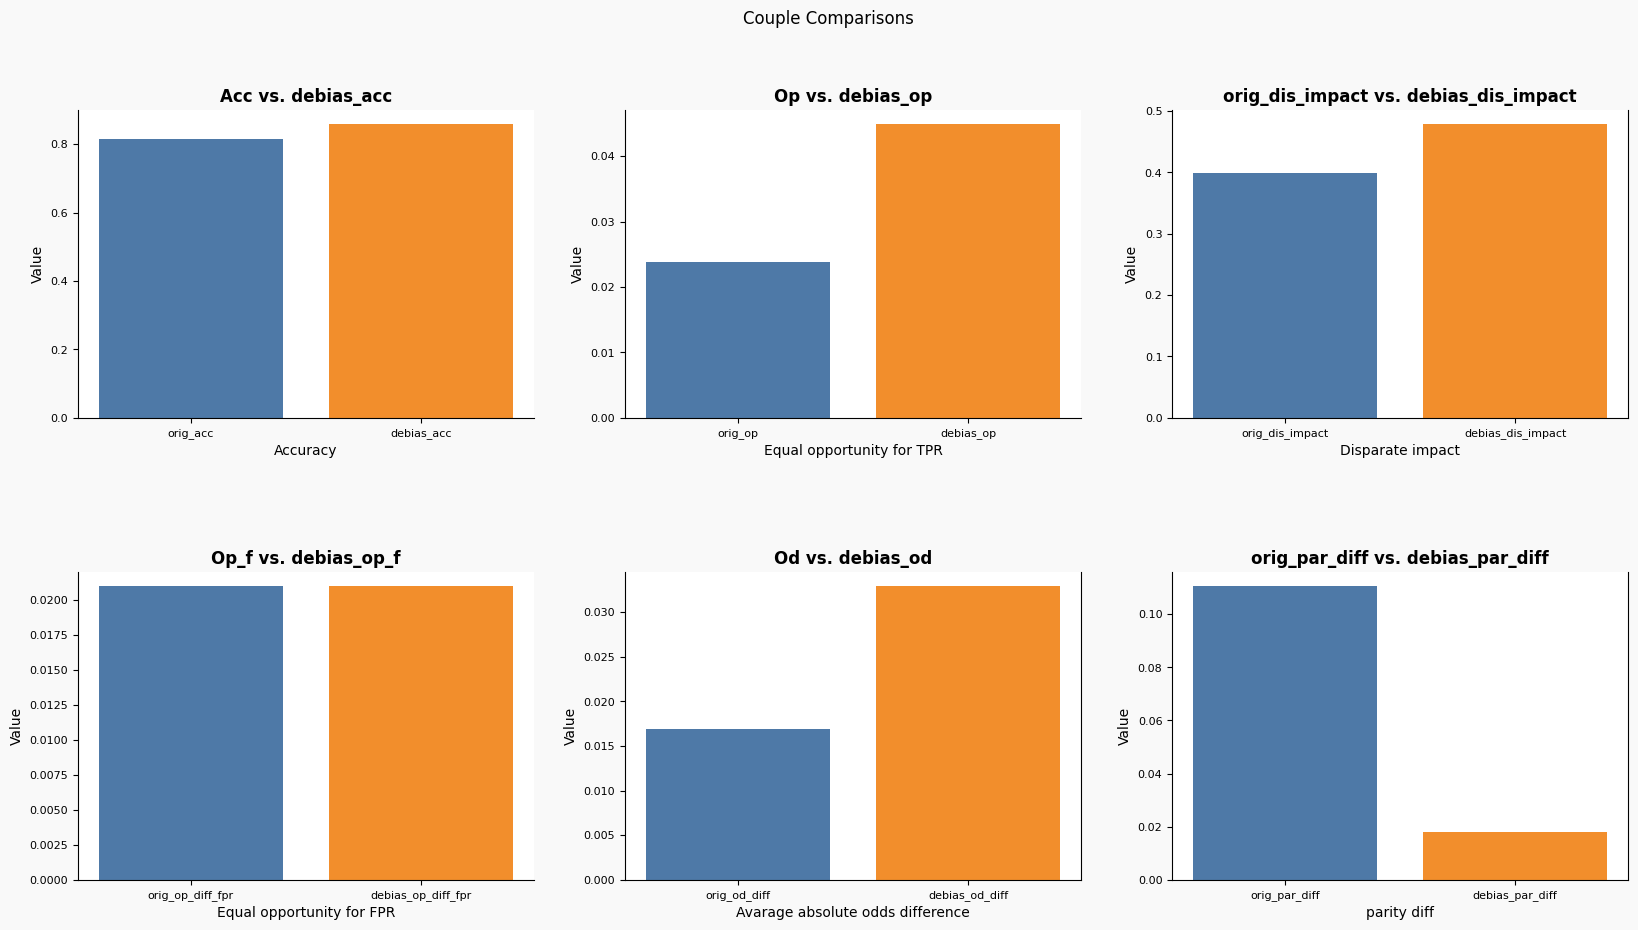

In [31]:
upsampled_acc, upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff, upsampled_dis_impact = fairness_metrics_roc_auc(Upsampled_df_features, y_upsampled)

# # Initialize wandb
# wandb.init(project="couple-comparisons")

# Create a bar plot for each couple comparison
fig, ax = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Couple Comparisons')

# Set background color
fig.patch.set_facecolor('#f9f9f9')

# Acc vs. Pois_acc plot
ax[0, 0].bar(['orig_acc', 'debias_acc'], [mean(orig_acc), mean(upsampled_acc)], color=['#4e79a7', '#f28e2c'])
ax[0, 0].set_title('Acc vs. debias_acc', fontsize=12, fontweight='bold')
ax[0, 0].set_xlabel('Accuracy', fontsize=10)
ax[0, 0].set_ylabel('Value', fontsize=10)
ax[0, 0].tick_params(axis='both', which='major', labelsize=8)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)

# Op vs. Pois_op plot
ax[0, 1].bar(['orig_op','debias_op'], [mean(orig_op_diff), mean(upsampled_op_diff)], color=['#4e79a7', '#f28e2c'])
ax[0, 1].set_title('Op vs. debias_op', fontsize=12, fontweight='bold')
ax[0, 1].set_xlabel('Equal opportunity for TPR', fontsize=10)
ax[0, 1].set_ylabel('Value', fontsize=10)
ax[0, 1].tick_params(axis='both', which='major', labelsize=8)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)

# Op_f vs. Pois_op_f plotdebias
ax[1, 0].bar(['orig_op_diff_fpr', 'debias_op_diff_fpr'], [mean(upsampled_op_diff_fpr), mean(upsampled_op_diff_fpr)], color=['#4e79a7', '#f28e2c'])
ax[1, 0].set_title('Op_f vs. debias_op_f', fontsize=12, fontweight='bold')
ax[1, 0].set_xlabel('Equal opportunity for FPR', fontsize=10)
ax[1, 0].set_ylabel('Value', fontsize=10)
ax[1, 0].tick_params(axis='both', which='major', labelsize=8)
ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)

# Od vs. Pois_od plot
ax[1, 1].bar(['orig_od_diff', 'debias_od_diff'], [mean(orig_od_diff), mean(upsampled_od_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 1].set_title('Od vs. debias_od', fontsize=12, fontweight='bold')
ax[1, 1].set_xlabel('Avarage absolute odds difference', fontsize=10)
ax[1, 1].set_ylabel('Value', fontsize=10)
ax[1, 1].tick_params(axis='both', which='major', labelsize=8)
ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines

# Od vs. Pois_od plot
ax[1, 2].bar(['orig_par_diff', 'debias_par_diff'], [mean(orig_par_diff), mean(upsampled_par_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 2].set_title('orig_par_diff vs. debias_par_diff', fontsize=12, fontweight='bold')
ax[1, 2].set_xlabel('parity diff', fontsize=10)
ax[1, 2].set_ylabel('Value', fontsize=10)
ax[1, 2].tick_params(axis='both', which='major', labelsize=8)
ax[1, 2].spines['top'].set_visible(False)
ax[1, 2].spines

# Od vs. Pois_od plot
ax[0, 2].bar(['orig_dis_impact', 'debias_dis_impact'], [mean(orig_dis_impact), mean(upsampled_dis_impact)], color=['#4e79a7', '#f28e2c'])
ax[0, 2].set_title('orig_dis_impact vs. debias_dis_impact', fontsize=12, fontweight='bold')
ax[0, 2].set_xlabel('Disparate impact', fontsize=10)
ax[0, 2].set_ylabel('Value', fontsize=10)
ax[0, 2].tick_params(axis='both', which='major', labelsize=8)
ax[0, 2].spines['top'].set_visible(False)
ax[0, 2].spines



In [32]:
# Record the end time
end_time = time.time()

In [33]:
# Calculate the elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.4f} minutes")

Elapsed time: 29.5869 minutes
